Our first method will use simple counting i.e. count the number of times each character is predicted based on two characters provided e.g. the name jane would defines n as the next characters after 'ja' so that would add to 'n' probability of being the next character 

In [847]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%pip install torch torchvision
import torch

Note: you may need to restart the kernel to use updated packages.


In [848]:
# Read in words
words = open('names.txt', 'r').read().splitlines()
words[:10]


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In this instance, we are only looking at three characters. Two input characters, and the character we are predicting next.

e.g. what characters are likely to follow r

we also now what names are likely to start and finish at


We then do a simple count of most prominent trigrams

How many examples do we get from emma?

<S>e -> m
em -> m
mm -> a
ma -> <E>

In [849]:
t = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>'] # hallucinate a start character and end character 
    for pair, ch2 in zip(zip(chs, chs[1:]), chs[2:]):
        trigram  = (''.join(pair), ch2)
        t[trigram] = t.get(trigram, 0) + 1

Now lets get the count of each combo and sort. we'll see that ah followed by ending character occurs the

In [850]:
sorted_t = sorted(t.items(), key = lambda kv: -kv[1])
sorted_t[:10]

[(('ah', '<E>'), 1714),
 (('na', '<E>'), 1673),
 (('an', '<E>'), 1509),
 (('on', '<E>'), 1503),
 (('<S>m', 'a'), 1453),
 (('<S>j', 'a'), 1255),
 (('<S>k', 'a'), 1254),
 (('en', '<E>'), 1217),
 (('ly', 'n'), 976),
 (('yn', '<E>'), 953)]

We need to create a lookup of integers to pairs so we can have an index. 
Basically we need an integer ref for all our points in our torch, that means each character pair needs an integer value, and each character needs a value e.g. ac = [100] and if it predicts d as next letter it would be axis point [100, 3]. Therefore each time this is shown, we add +1, allowing us to count the number of occurences 

If I understand this correctly, we therefore need two integer lookups: 
-
Taking our char pairs as the 'y' axis - we need 0:len(unique-pairs)  i.e. 0-600 and then our single character axis being x axis, we need 28 chars (alphabet including <S> and <E>)

0   |------------------------------| 28
    |<S>aa   <S>ab  <S>ac
    |aaa     aab    aac
    |..
    |..
    |..
784 |zaa zab

Lets get the character string to integer index for our 'y-axis' which is a - z and our <S> and <E> characters

In [852]:
# returns all the set of lowercase characters
chars = sorted(set(''.join(words)))
char_to_integer = {s:i for i,s in enumerate(chars)}
char_to_integer['<S>'] = 26
char_to_integer['<E>'] = 27
print(list(char_to_integer)[:10])

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']


Lets convert our trigram to an array. We need to deduce how many rows we have, so it should be all the combinations of characters against our list of 28 chars.

28 characters consist of 26 alphabet characters plus our <S> and <E> characters. So as we can pair same characters together e.g. -> a,a and with the other 27 chars, there is a total of 28*28 combinations -> 784 (minus some impossible combos e.g. <S><E> a<S> <E>s)

Note we can remove all pairs that begin with <E> as its not possible to start on an end character

In [854]:
import string

# Create a list of all lowercase letters plus <S> and <E>
letters = list(string.ascii_lowercase) + ["<S>", "<E>"]

# Create a list of tuples where the first element is a pair of characters and the second element is an integer index
pairs_string_to_integer = [(a+b, i) for i, (a, b) in enumerate((x, y) for x in letters for y in letters)]

## And finally convert this to dictionary so we can do lookups
pairs_string_to_integer = dict(pairs_string_to_integer)
pairs_string_to_integer['fa']

# Remove all keys where <S> is the second character
pairs_string_to_integer = {key: value for key, value in pairs_string_to_integer.items() if not key.endswith('<S>')}

# Remove all keys where <E> is the first character
pairs_string_to_integer = {key: value for key, value in pairs_string_to_integer.items() if not key.startswith('<E>')}

# Remove <S><E> as not possible
pairs_string_to_integer = {key: value for key, value in pairs_string_to_integer.items() if not key == ("<S><E>")}

# Reset the indices
pairs_string_to_integer = {key: i for i, (key, value) in enumerate(pairs_string_to_integer.items())}

print(pairs_string_to_integer)


{'aa': 0, 'ab': 1, 'ac': 2, 'ad': 3, 'ae': 4, 'af': 5, 'ag': 6, 'ah': 7, 'ai': 8, 'aj': 9, 'ak': 10, 'al': 11, 'am': 12, 'an': 13, 'ao': 14, 'ap': 15, 'aq': 16, 'ar': 17, 'as': 18, 'at': 19, 'au': 20, 'av': 21, 'aw': 22, 'ax': 23, 'ay': 24, 'az': 25, 'a<E>': 26, 'ba': 27, 'bb': 28, 'bc': 29, 'bd': 30, 'be': 31, 'bf': 32, 'bg': 33, 'bh': 34, 'bi': 35, 'bj': 36, 'bk': 37, 'bl': 38, 'bm': 39, 'bn': 40, 'bo': 41, 'bp': 42, 'bq': 43, 'br': 44, 'bs': 45, 'bt': 46, 'bu': 47, 'bv': 48, 'bw': 49, 'bx': 50, 'by': 51, 'bz': 52, 'b<E>': 53, 'ca': 54, 'cb': 55, 'cc': 56, 'cd': 57, 'ce': 58, 'cf': 59, 'cg': 60, 'ch': 61, 'ci': 62, 'cj': 63, 'ck': 64, 'cl': 65, 'cm': 66, 'cn': 67, 'co': 68, 'cp': 69, 'cq': 70, 'cr': 71, 'cs': 72, 'ct': 73, 'cu': 74, 'cv': 75, 'cw': 76, 'cx': 77, 'cy': 78, 'cz': 79, 'c<E>': 80, 'da': 81, 'db': 82, 'dc': 83, 'dd': 84, 'de': 85, 'df': 86, 'dg': 87, 'dh': 88, 'di': 89, 'dj': 90, 'dk': 91, 'dl': 92, 'dm': 93, 'dn': 94, 'do': 95, 'dp': 96, 'dq': 97, 'dr': 98, 'ds': 99, 'dt

In [855]:
## Creates a 784 * 28 tensor that is empty initially
import torch

N = torch.zeros((len(pairs_string_to_integer), 28), dtype=torch.int32) # 28*28 = 784 for different pair combos
N[:5]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]], dtype=torch.int32)

Now add our counts of each character to the tensor i.e. all counts of aab -> zzz occuring

Each time e.g. ab pair with pred c comes up, we add a count to the co-ordinates in the tensor. As a result, we get the probability of each pair and next character occuring

In [856]:
for w in words:
    chs = ['<S>'] + list(w) + ['<E>'] # hallucinate a start character and end character 
    for pair, ch2 in zip(zip(chs, chs[1:]), chs[2:]):
        trigram  = (''.join(pair), ch2) #  e.g. ('<S>e', 'm')
        pairs_combined = trigram[0] #  e.g '<S>e'
        print
        ix1 = pairs_string_to_integer[pairs_combined]
        ix2 = char_to_integer[ch2]
        N[ix1, ix2] += 1  

In [857]:
N[10]

tensor([121,   2,   0,   0,  98,   0,   0,  30,  99,   0,   3,  27,   0,   0,
         48,   0,   0,   4,  40,   1,   9,   0,   0,   0,  52,   0,   0,  34],
       dtype=torch.int32)

In [772]:
%pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


Create an inverse of string to integer, this way we can look up our characters based on the cordinates in our tensor N

In [858]:
pred_itos = {i:s for s,i in char_to_integer.items()}
pair_itos = {i:s for s,i in pairs_string_to_integer.items()}
pair_itos[100]

'dt'

(-0.5, 27.5, 728.5, -0.5)

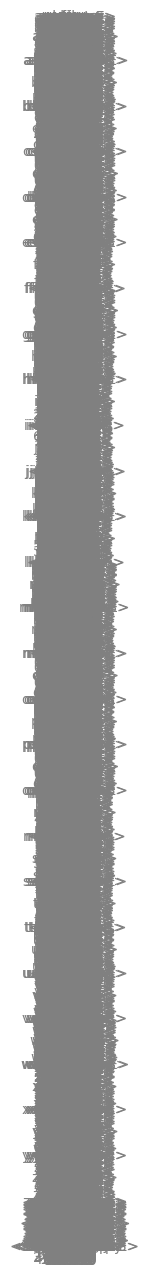

In [707]:
# TODO: FIX THIS
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(len(pair_itos)):
    for j in range(len(pred_itos)):
        chstr = pair_itos[i] + pred_itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis('off')

Convert the counts to proabilities of what character a pair will predict next. We add 0.01 to avoid predicting a pair which was 0 occurrences, that would result in / 0.

In [859]:
P = (N+0.01).float()  
P /= P.sum(1, keepdims=True)
P[1]

tensor([5.1748e-02, 3.6968e-02, 1.8659e-03, 1.2010e-01, 3.1963e-01, 1.8475e-05,
        1.8475e-05, 3.3273e-02, 1.4043e-01, 1.8475e-05, 1.8475e-05, 1.8493e-02,
        1.8475e-05, 3.7134e-03, 7.4084e-03, 1.8475e-05, 1.8475e-05, 1.5705e-01,
        9.2558e-03, 1.8475e-05, 1.1103e-02, 1.8475e-05, 1.8475e-05, 1.8475e-05,
        2.2188e-02, 1.8475e-05, 1.8475e-05, 6.6527e-02])

For sampling we will use torch.multinomial and a generator object to make everything deterministic 

This line of code is using PyTorch, a popular machine learning library in Python. 

The `torch.Generator()` is an object that holds the state of the random number generator. You can think of it as a container for the algorithm that produces pseudo-random numbers.

The `manual_seed()` function is used to set the seed for generating random numbers. This ensures that the random numbers generated are deterministic, meaning if you use the same seed, you will get the same sequence of random numbers. This is useful for debugging and testing purposes, as it allows for reproducibility in your code.

In [860]:
g = torch.Generator().manual_seed(2147483647)

Logic -> We predict the 3rd character from the beginning two e.g. em -> a. 
We then strip the first character and append our 3rd character for the next prediction i.e. ma -> b

- Starting off the prediction, we need to start on <S>(x) character

In [861]:
start_chars = []
for key, value in pair_itos.items():
    if '<S>' in str(value):
        start_chars.append((key, value))
start_chars[:10]

[(702, '<S>a'),
 (703, '<S>b'),
 (704, '<S>c'),
 (705, '<S>d'),
 (706, '<S>e'),
 (707, '<S>f'),
 (708, '<S>g'),
 (709, '<S>h'),
 (710, '<S>i'),
 (711, '<S>j')]

Note - When we run through predictions, we need to predict like ab -> c -> bc -> d -> cd -> e
Therefore we need to combine the second character in the pair with the predicted value. This is demonstrated below.

Note: -1 gets the last character from a string

In [862]:
ix_pair = pair_itos[10][-1] + pred_itos[10] 
ix_pair

pairs_string_to_integer[ix_pair]
P[45]

tensor([0.2428, 0.0012, 0.0012, 0.0012, 0.1220, 0.0012, 0.0012, 0.1220, 0.2428,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.1220, 0.0012, 0.0012, 0.0012,
        0.0012, 0.1220, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012])

In [898]:
import random
g = torch.Generator().manual_seed(214748347)

for i in range(10):
    # Select a random value from start_chars
    out = []
    start_ix = random.choice(start_chars) # Gets all pairs that start with <S> 
    ix_pair = start_ix[0] # Gets integer reference for pair e.g. fe -> 45
    out.append(start_ix[1]) # Append the first start characters
    while True:
        p = P[ix_pair]
        iy_pred_reference = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(pred_itos[iy_pred_reference])
        if '<E>' in pred_itos[iy_pred_reference]:
            break
        # Combines last letter of pair and predicted char e.g. xy predicts z  so ix_pair now equals  = yz 
        # if '<S>' in pair_itos[ix_pair]:

        ix_pair_str = pair_itos[ix_pair][-1] + pred_itos[iy_pred_reference] 
        
        # Convert ix back to an integer reference
        ix_pair = pairs_string_to_integer[ix_pair_str]


    print(''.join(out))


<S>kallena<E>
<S>hon<E>
<S>kaylim<E>
<S>bla<E>
<S>ne<E>
<S>favielibrallaur<E>
<S>cobelae<E>
<S>mali<E>
<S>cera<E>
<S>siershi<E>


Now lets look at calculating the loss function to check the quality of the model

GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
equivalent to maximizing the log likelihood (because log is monotonic)
equivalent to minimizing the negative log likelihood
equivalent to minimizing the average negative log likelihood

log(a*b*c) = log(a) + log(b) + log(c)

In [913]:
log_likelihood = 0.0
n = 0 
for w in words:
    chs = ['<S>'] + list(w) + ['<E>'] # hallucinate a start character and end character 
    for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
        pair_combined = pair[0] + pair[1]
        ix1 = pairs_string_to_integer[pair_combined]
        ix2 = char_to_integer[ch]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n +=1 
        # print(f'{pair}{ch}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood}')

negative_log_liklihood = -log_likelihood
print(f'{negative_log_liklihood=}')
print(f'{negative_log_liklihood/n}') # Average log likelihood


-404493.21875
negative_log_liklihood=tensor(404493.2188)
2.062551736831665


# Method 2  - Neural Net and gradient descent

In [ ]:
# Create a training set of all the trigrams (ab,c)
xs, ys = [], []

for w in words[:1]:
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = string_to_integer[ch1]
        ix2 = string_to_integer[ch2]
        print(ch1,ch2)
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
